In [44]:
from dotenv import dotenv_values
import httpx
import pandas as pd
import matplotlib.pyplot as plt
import time

In [45]:
def plot_sma_ratios(df_merged):
    df_merged['SMA_ratio_agix'] = df_merged['SMA_agix'] / df_merged['SMA_fetch']
    df_merged.plot(x='timestamp', y='SMA_ratio_agix', kind='line')
    plt.xlabel(xlabel='Timestamp')
    plt.ylabel(ylabel='Price Ratio')
    plt.title(label='Ratio of Price Differences over Time (SMA_agix / SMA_fetch)')
    plt.show()

    df_merged['SMA_ratio_ocean'] = df_merged['SMA'] / df_merged['SMA_fetch']
    df_merged.plot(x='timestamp', y='SMA_ratio_ocean', kind='line')
    plt.xlabel(xlabel='Timestamp')
    plt.ylabel(ylabel='Price Ratio')
    plt.title(label='Ratio of Price Differences over Time (SMA_ocean / SMA_fetch)')
    plt.show()

In [46]:
def plot_price_ratio(df_merged):
    plt.plot(df_merged['timestamp'], df_merged['SMA_ratio_agix'], label='AGIX')
    plt.plot(df_merged['timestamp'], df_merged['SMA_ratio_ocean'], label='OCEAN')
    plt.xlabel(xlabel='Timestamp')
    plt.ylabel(ylabel='Price Ratio')
    plt.title(label='Ratio of Price Differences over Time, for OCEAN and AGIX')
    plt.legend()
    plt.show()

In [47]:
def plot_sma(df_merged):
    plt.plot(df_merged['timestamp'], df_merged['SMA_agix'], label='AGIX')
    plt.plot(df_merged['timestamp'], df_merged['SMA_fetch'], label='FET')
    plt.plot(df_merged['timestamp'], df_merged['SMA'], label='OCEAN')
    plt.xlabel(xlabel='Timestamp')
    plt.ylabel(ylabel='Prices in USD')
    plt.title(label="SMA of Fetch and AGIX in USD")
    plt.legend()
    plt.show()

In [48]:
def calculate_average_sma_ratios(df_merged):
    average_sma_ratio_ocean = df_merged['SMA_ratio_ocean'].mean()
    average_sma_ratio_agix = df_merged['SMA_ratio_agix'].mean()
    print(f"average SMA ratio of OCEAN: {average_sma_ratio_ocean}")
    print(f"average SMA ratio of AGIX: {average_sma_ratio_agix}")

In [49]:
def pretty_plot_with_sma(df: pd.DataFrame, token_name: str):
    # Plot the dataframe with the SMA
    df.plot(x='timestamp', y=['prices', 'SMA'], kind='line')
    plt.xlabel(xlabel='Timestamp')
    plt.ylabel(ylabel='Prices')
    plt.title(label=f'SMA of {token_name} in USD')
    plt.legend(['Prices', 'SMA'])
    plt.show()

 This is the price comparison for the last 365 days


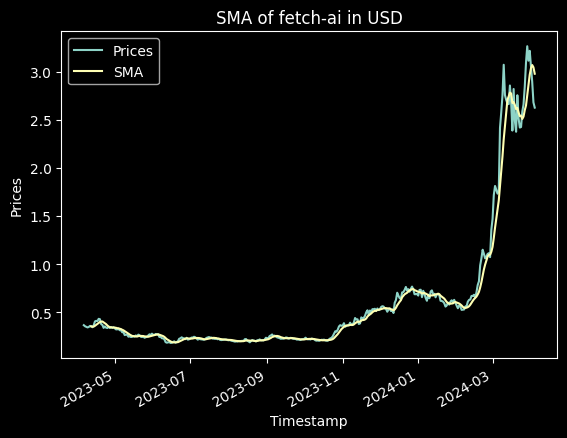

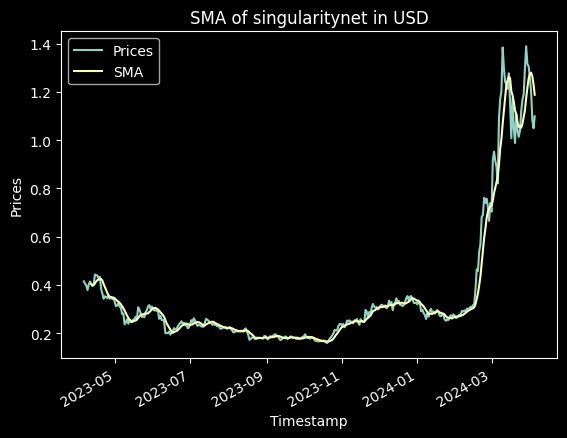

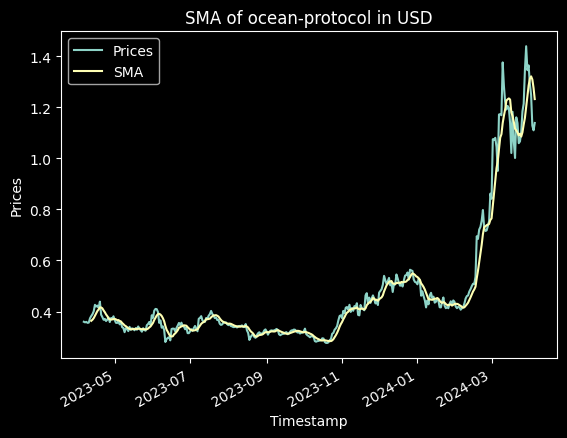

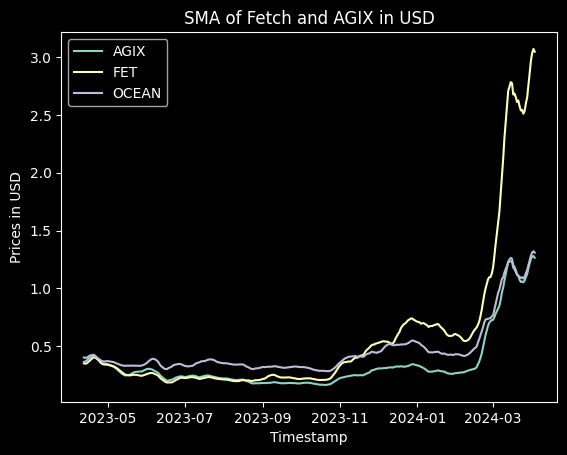

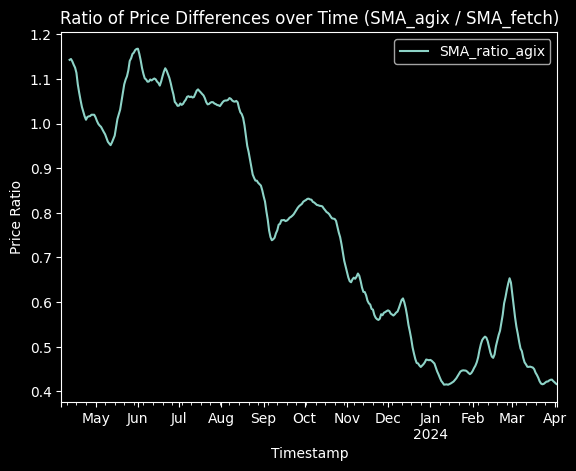

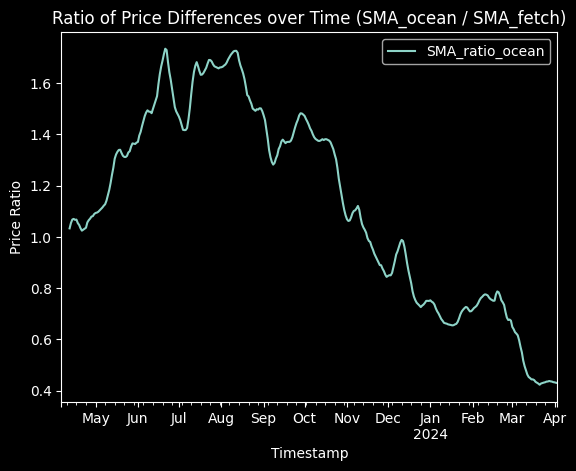

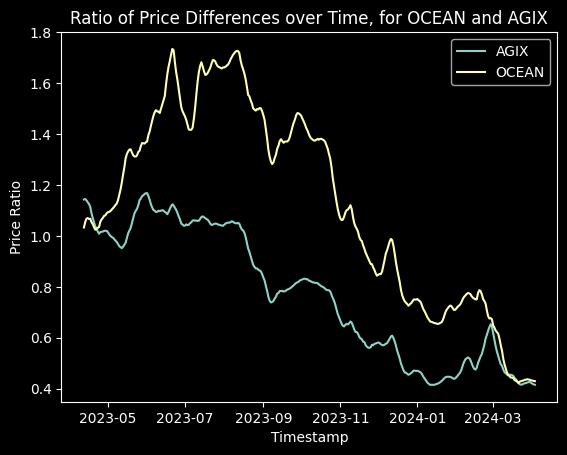

average SMA ratio of OCEAN: 1.1255542536439775
average SMA ratio of AGIX: 0.7706006098076756
 This is the price comparison for the last 180 days


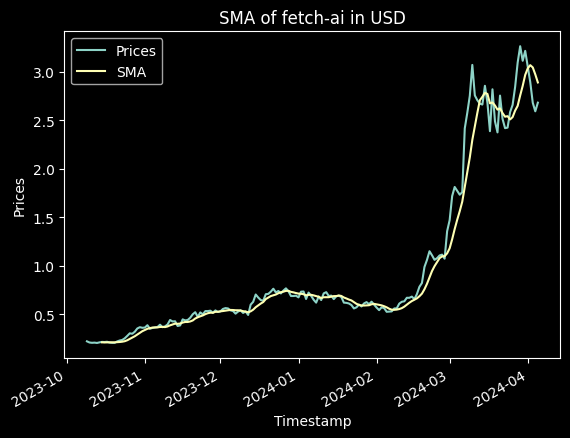

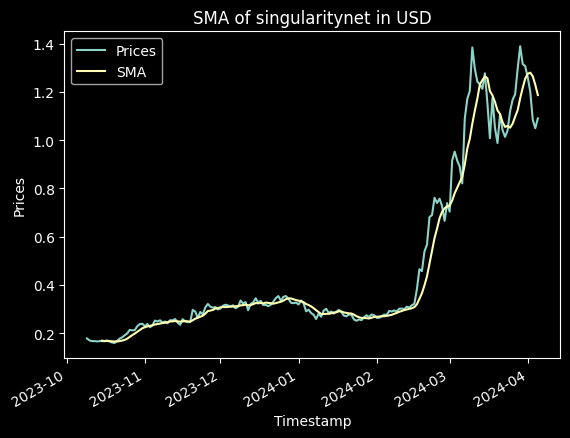

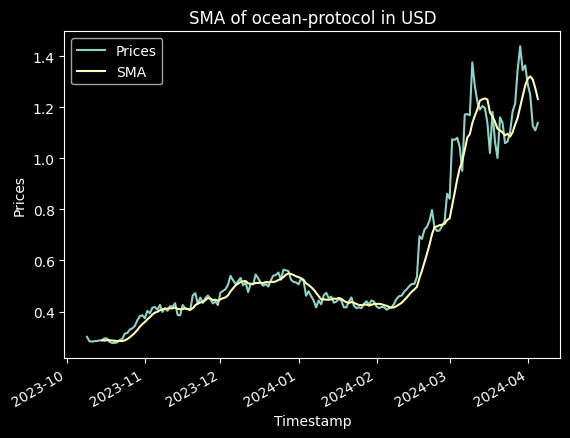

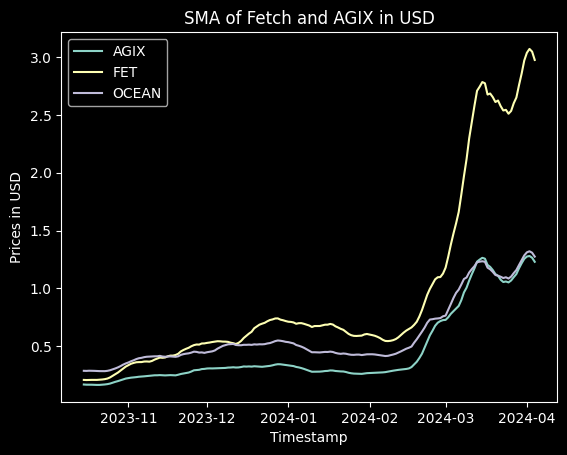

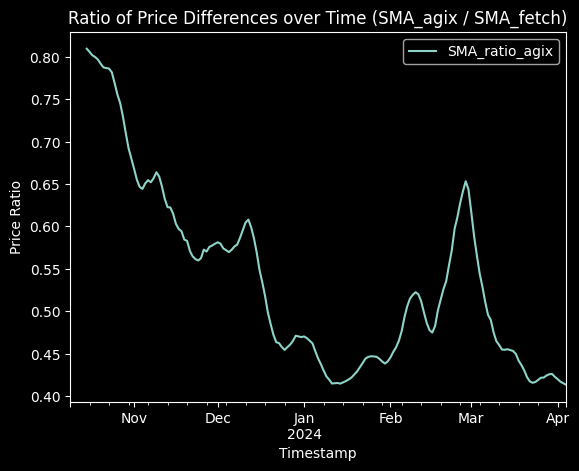

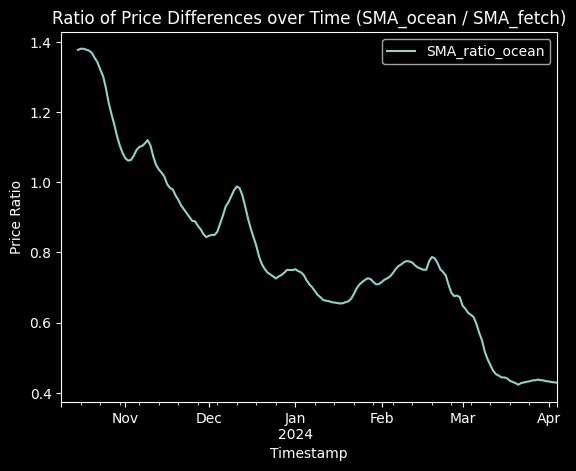

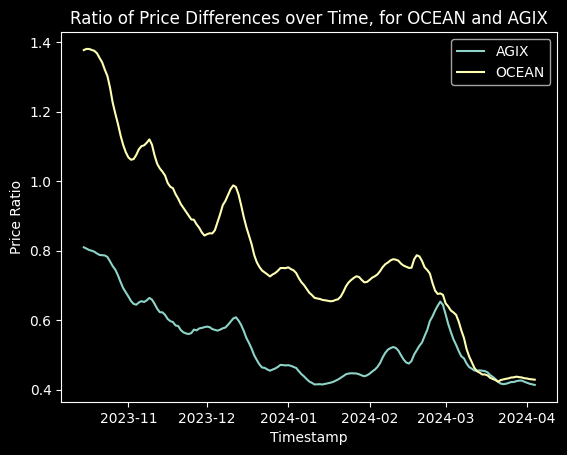

average SMA ratio of OCEAN: 0.794768539813673
average SMA ratio of AGIX: 0.5358610306469235
 This is the price comparison for the last 90 days


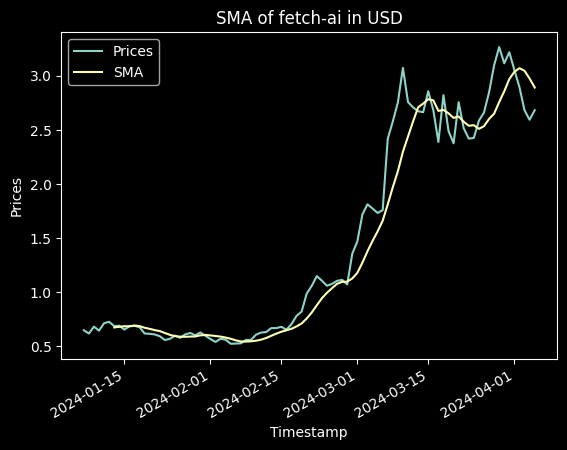

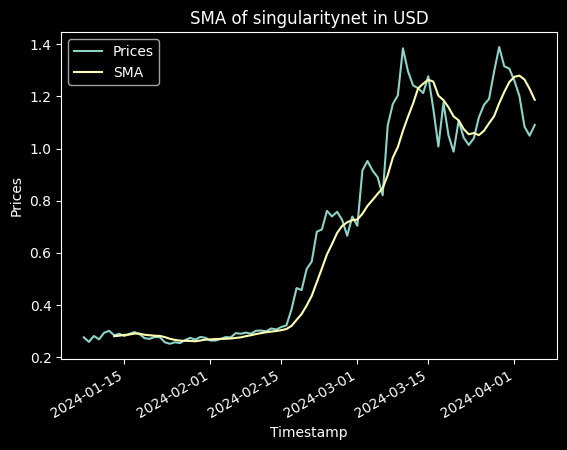

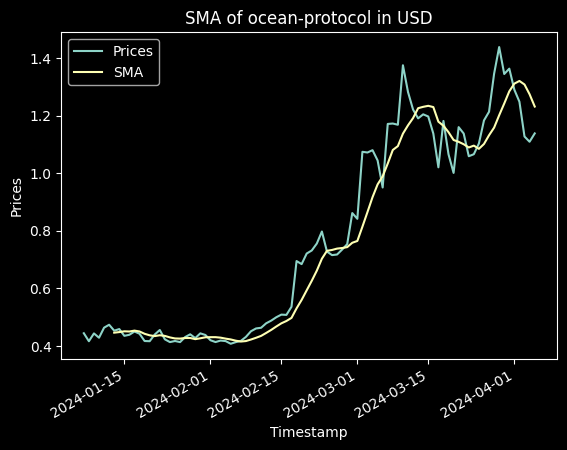

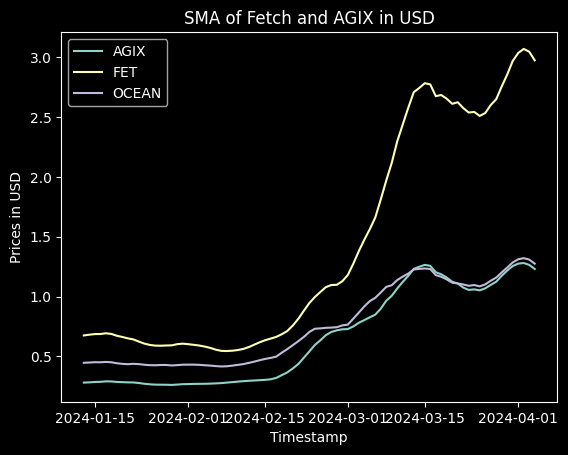

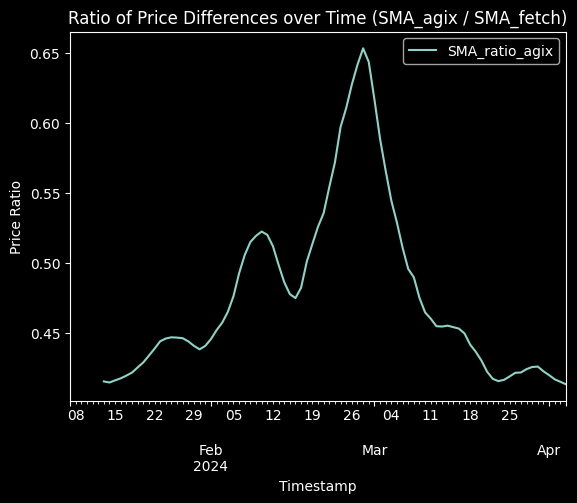

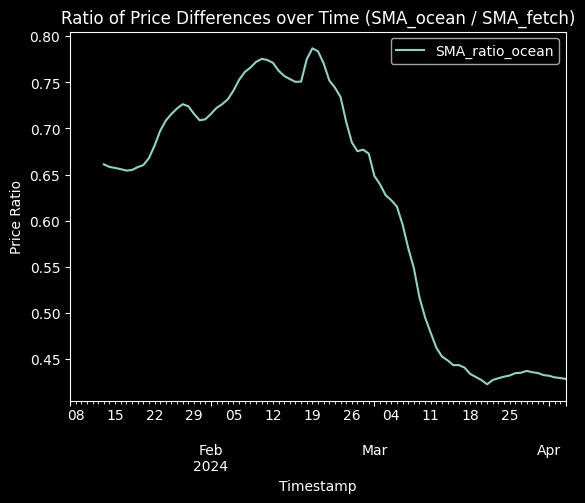

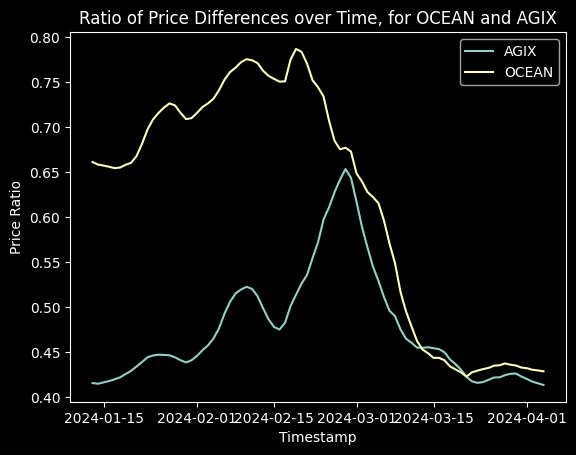

average SMA ratio of OCEAN: 0.6192264727860383
average SMA ratio of AGIX: 0.47682841329096215
 This is the price comparison for the last 30 days


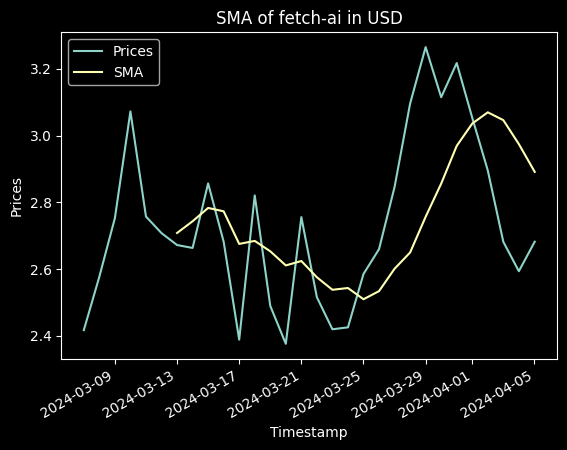

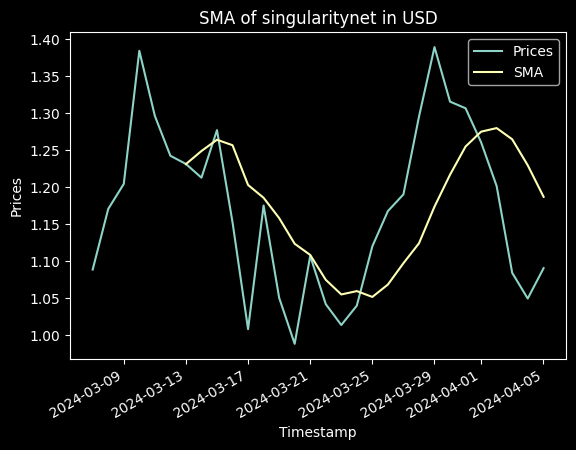

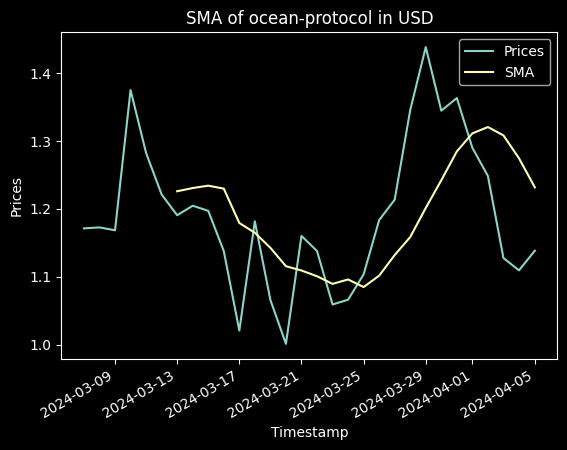

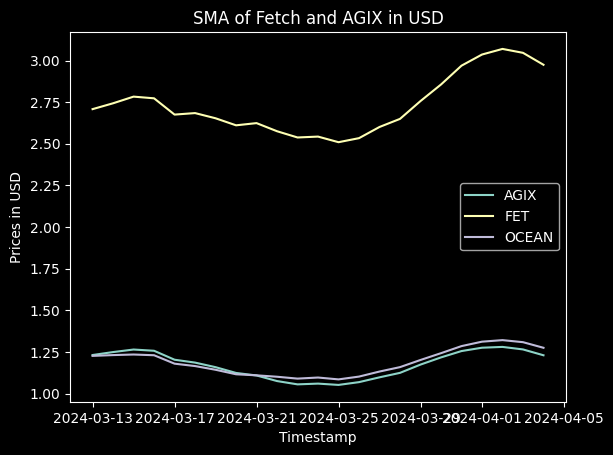

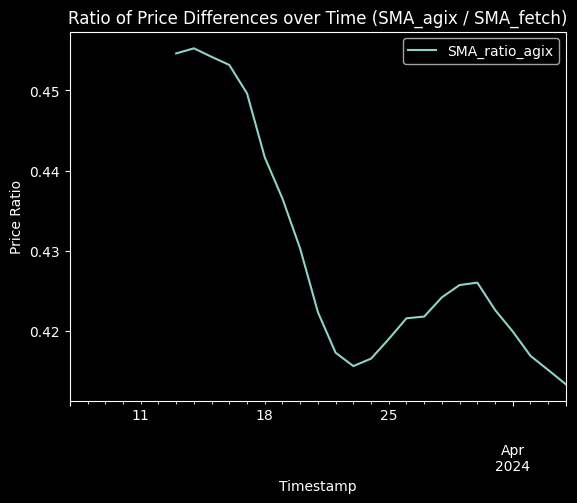

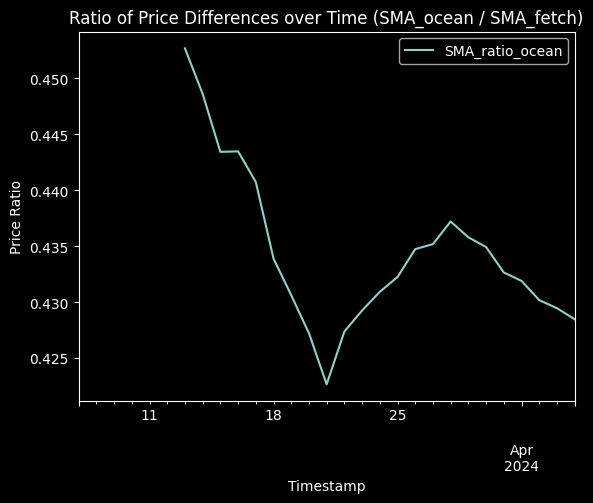

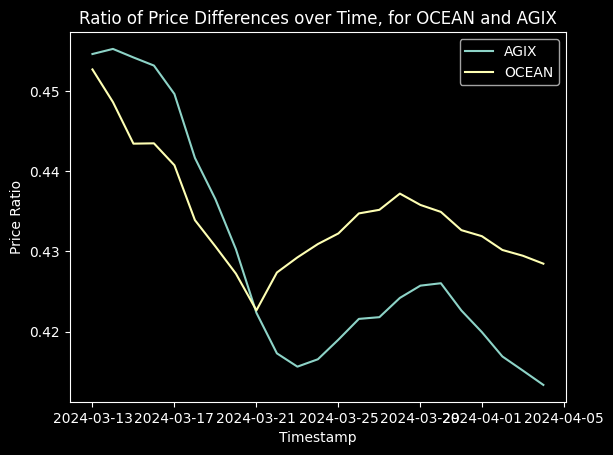

average SMA ratio of OCEAN: 0.43451505379371885
average SMA ratio of AGIX: 0.42928889296106887
 This is the price comparison for the last 15 days


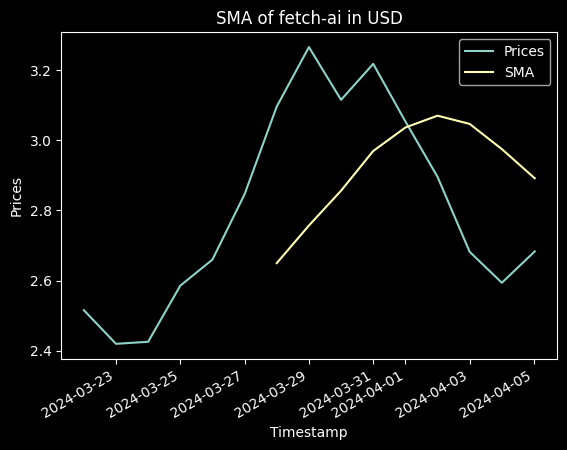

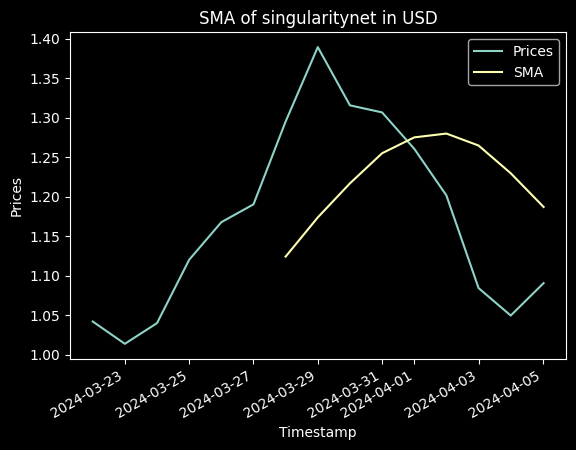

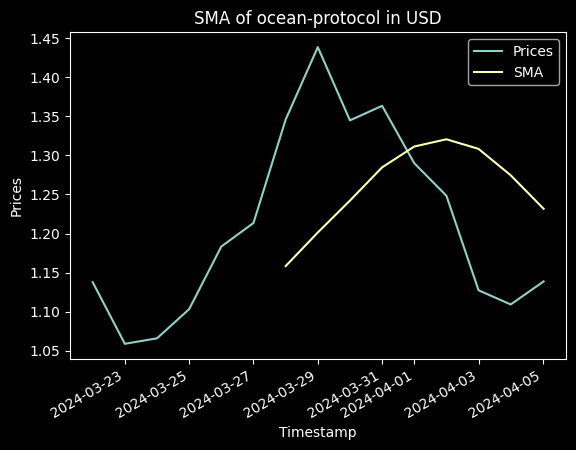

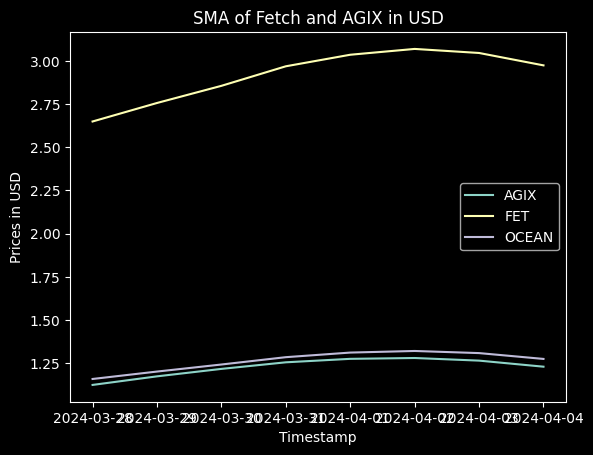

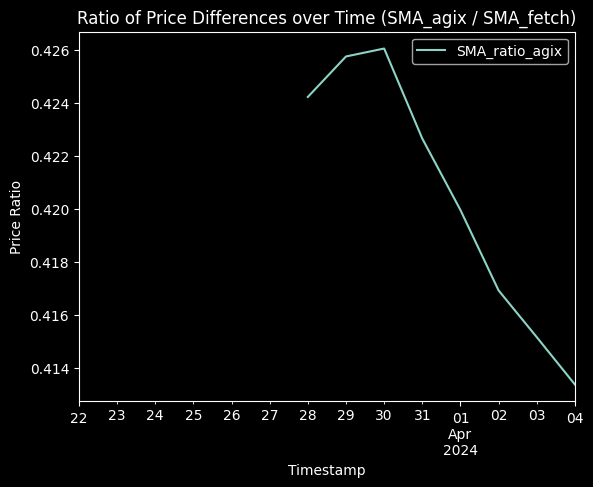

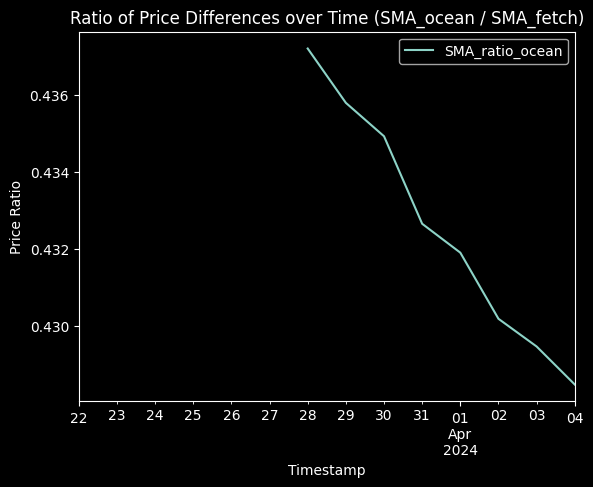

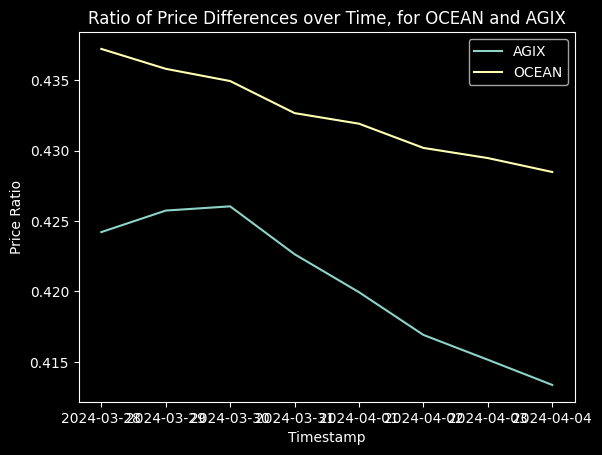

average SMA ratio of OCEAN: 0.4325827881677937
average SMA ratio of AGIX: 0.42050496866301507


In [50]:
def clean_data(data: dict, rolling_window: int = 30):
    # Initialize an empty DataFrame
    df = pd.DataFrame()

    # Process each category in the JSON data
    for key in data.keys():
        # Convert the data into a temporary DataFrame
        temp_df = pd.DataFrame(data[key], columns=['timestamp', key])
        
        # If our main DataFrame is empty, start it with this category's DataFrame
        if df.empty:
            df = temp_df
        else:
            df = pd.merge(left=df, right=temp_df, on='timestamp', how='outer')
    df['timestamp'] = pd.to_datetime(arg=df['timestamp'], unit='ms')
    df['SMA'] = df['prices'].rolling(window=rolling_window).mean()
    
    return df


def main(token: str, time_window: int = 365):
    api = dotenv_values(dotenv_path=".env")["API_KEY"]
    params = {
        'vs_currency': 'usd',
        'days': str(time_window),
        'interval': 'daily',
        'precision': 'full',
        'x_cg_demo_api_key': api,
    }
    url = f"https://api.coingecko.com/api/v3/coins/{token}/market_chart"
    session = httpx.Client()
    response = session.get(url=url, params=params)
    data = clean_data(data=response.json(), rolling_window=7)
    pretty_plot_with_sma(df=data, token_name = token)
    return data

if __name__ == "__main__":
    time_window = [365, 180, 90, 30, 15]
    for window in time_window:
        print(f" This is the price comparison for the last {window} days")
        df_fetch = main(token="fetch-ai", time_window=window)
        df_agix = main(token="singularitynet", time_window=window)
        df_ocean = main(token="ocean-protocol", time_window=window)
        df_merged = df_agix.merge(right=df_fetch,on='timestamp', suffixes=("_agix", "_fetch")).merge(right=df_ocean,on='timestamp', suffixes=("", "_ocean"))
        plot_sma(df_merged=df_merged)
        plot_sma_ratios(df_merged=df_merged)
        plot_price_ratio(df_merged=df_merged)     
        calculate_average_sma_ratios(df_merged=df_merged)
        time.sleep(5) # Sleep for 10 seconds to avoid rate limiting